# Team Members
1. Aaron Khoo
2. Calvin Yusnoveri (1002911)
3. Amarjyot Kaur Narula
4. Joseph Chng (1003811)

# Task Description

As COVID-19 impacts our daily routine and changed the norms that we accepted prior to the pandemic, there are some interests in quantifying its impacts on the global stage. One way to measure such impact is to monitor the explosion of activity in social media usage such as Twitter and Youtube, where most people who are not able to move freely, shares their thoughts through such platforms. Twitter in particular, provides a platform that allows the users to post their thoughts in a succint manner and add hashtags or mentions to increase the tweet's exposure on the platform. Our task will thus be to predict the number of retweets a tweet that is COVID-19 related will have using the TweetsCOV-19 dataset.

At the end of this project, we created a Linear Regression Model and an interactive GUI to predict a "ballpark" value of retweet count based on input parameters found in TweetsCOV-19 dataset. Custom values can also be input into the model.

![Final Result](assets/gui-result.PNG)

# Dataset Description

The dataset that is used for this project is obtained from the COVID-19 Retweet Prediction Challenge. For this prediction model, we used Part 1 (Oct 2019 - April 2020) dataset for training and Part 2 (May 2020 - May 2020) for testing obtained from https://data.gesis.org/tweetscov19/#dataset.

From the dataset, there are different features for the tweet data that we obtain and the feature description are as follows:

1. Tweet Id: Long. Unique ID for a specific tweet
2. Username: String. Username of the user that published the tweet which is encrypted for privacy.
3. Timestamp: Format ( "EEE MMM dd HH:mm:ss Z yyyy" ). Specific time and date of the tweet
4. #Followers: Integer. Number of followers of the Twitter user who posted the tweet.
5. #Friends: Integer. Number of friends that the Twitter user who posted the tweet.
6. #Retweets: Integer. Number of retweets that the tweet has obtained and is the label for this project.
7. #Favorites: Integer. Number of favorites for the tweet
8. Entities: String. The entities of the tweet is obtained by aggregating the original text. Every annotated entity will then have its produced score from FEL library. Each entity is separated by char ":" to store the entity in this form "original_text:annotated_entity:score;". Each entity is separated from another entity by char ";".Any tweet that has no corresponding entities will be stored as "null;".
9. Sentiment: String. SentiStrength produces a score for positive (1 to 5) and negative (-1 to -5) sentiment. The two sentiments are splitted by whitespace char " ". Positive sentiment was stored first and followed by negative sentiment (i.e. "2 -1").
10. Mentions: String. Contains mentions and concatenate them with whitespace char " ". If there is no mention, it is stored as "null;".
11. Hashtags: String. Contains hashtags and concatenate the hashtags with whitespace char " ". If there is no hashtag, it is stored as "null;".
12. URLs: String: Contains URLs and concatenate the URLs using ":-: ". If there is no URL, it is stored as "null;"

In [13]:
# imports

import logging
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec

import test
import predict

from model import LinReg2

In [5]:
header = [
    "Tweet Id", 
    "Username", 
    "Timestamp", 
    "#Followers",
    "#Friends",
    "#Retweets",
    "#Favorites",
    "Entities",
    "Sentiment",
    "Mentions",
    "Hashtags",
    "URLs"]

data = pd.read_csv("./data/TweetsCOV19_052020.tsv.gz", compression='gzip', names=header, sep='\t', quotechar='"')
data.head(5)

,Tweet Id,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs
0,1255980348229529601,fa5fd446e778da0acba3504aeab23da5,Thu Apr 30 22:00:24 +0000 2020,29697,24040,0,0,null;,1 -1,null;,Opinion Next2blowafrica thoughts,null;
1,1255981220640546816,547501e9cc84b8148ae1b8bde04157a4,Thu Apr 30 22:03:52 +0000 2020,799,1278,4,6,null;,1 -1,null;,null;,null;
2,1255981244560683008,840ac60dab55f6b212dc02dcbe5dfbd6,Thu Apr 30 22:03:58 +0000 2020,586,378,1,2,null;,2 -1,null;,null;,https://www.bbc.com/news/uk-england-beds-bucks...
3,1255981472285986816,37c68a001198b5efd4a21e2b68a0c9bc,Thu Apr 30 22:04:52 +0000 2020,237,168,0,0,null;,1 -1,null;,null;,https://lockdownsceptics.org/2020/04/30/latest...
4,1255981581354905600,8c3620bdfb9d2a1acfdf2412c9b34e06,Thu Apr 30 22:05:18 +0000 2020,423,427,0,0,i hate u:I_Hate_U:-1.8786140035817729;quaranti...,1 -4,null;,null;,null;


# Preprocessing and Feature Engineering

In order to train our prediction model, we have also done some preprocessing of the features that are available in the dataset. All these changes to the raw features allow us to link these processed features to the final retweet prediction in a more precise manner. 

Clean Data (Final structure/form of data before it is fed into the model):

1. #Followers: Float. Log transformed: `log_10(x + 1)`
2. #Friends: Float. Log transformed: `log_10(x + 1)`
3. #Favorites: Float. Log transformed: `log_10(x + 1)`
4. Positive (Sentiment): Float. Scaled. `x/5`
5. Negative (Sentiment): Float. Scaled. `x/-5`
6. Sentiment Disparity: Float. Scaled. `x/10`
7. No. of Entities: Float. Log transformed: `log_10(x + 1)`
8. Day of Week: Float. One-Hot Vector. (7, ) Vector.
9. Time Int: Float. Log transformed: `log_10(x + 1)`
10. Hashtags Embedding: Float. One-Hot Vector. (25, ) Vector.
11. Mentions Embedding: Float. One-Hot Vector. (25, ) Vector.
12. #Followers Min, Max, Mean: Float. Log transformed: `log_10(x + 1)`
12. #Friends Min, Max, Mean: Float. Log transformed: `log_10(x + 1)`
12. #Retweets Min, Max, Mean: Float. Log transformed: `log_10(x + 1)`
12. #Favorites Min, Max, Mean: Float. Log transformed: `log_10(x + 1)`

In total, the input dimension (first layer) is `8 + 7 + 25 + 25 + 12 = (77, )`.

The target is: #Retweets: Integer. Log transformed: `log_10(x + 1)`

## Hashtags & Mentions

Both Hashtags and Mentions are in the form of list of Strings seperated by whitespace. Thus, in order to create tractable input for the model, embeddings are created for both the Hashtags and Mentions of size `(25, )`.

In [19]:
hashtag_embeddings = Word2Vec.load('./data/hashtag_embeddings')
mention_embeddings = Word2Vec.load('./data/mention_embeddings')

hashtags_vocab = hashtag_embeddings.wv.index_to_key
mentions_vocab = mention_embeddings.wv.index_to_key

print(hashtags_vocab[:5]) # example of hashtags key
print(mentions_vocab[:5]) # example of mentions key

['COVID19', 'coronavirus', 'Covid_19', 'covid19', 'May']
['realDonaldTrump', 'PMOIndia', 'narendramodi', 'jaketapper', 'YouTube']


In [21]:
hashtags_example = 'COVID19'
mentions_example = 'realDonaldTrump'

print(f"{hashtags_example} -> {hashtags_embeddings.wv[hashtags_example]}")
print(f"{mentions_example} -> {mentions_embeddings.wv[mentions_example]}")

COVID19 -> [ 0.10622272  0.26996937 -0.46450084  0.10561462 -0.5595082   0.26207525
  0.28835535  0.80339587  0.30626374 -0.13036335  0.8120623  -0.46314418
  0.20126966 -0.9723947  -1.0051426  -0.04809839  0.4593365   0.09532893
 -0.21894015 -0.23557915  0.42107382  0.4622469   0.53460604 -0.589559
  0.6296402 ]
realDonaldTrump -> [ 0.5991303  -0.10410535  0.23690729 -0.23115875 -0.961905   -0.11418784
  0.12405131  0.4196795  -1.493182   -0.20270342  1.2276924  -1.3593616
 -0.19556278  0.27365074  0.32451993  1.9415929  -0.20647514 -0.17526582
 -0.69910485 -1.6436449   1.3161302  -0.17269903 -0.5424232   1.0386076
  1.062889  ]


These embeddings are trained over 5 epoch and only considers String symbols that occur at least 200 times to be relevant. This is done by passing the argument `min_count=200`, when training. The hashtags and mentions vocabularies are saved in: `data`.

Using these embeddings, both Hashtags and Mentions column are iterated over and converted into vectors of size `(25, )`. With these rules:

- For those Hashtags/Mentions cells that contain `null`, 0 vector of size 25 is outputted
- For those Hashtags/Mentions cells that contain String symbols that occur than less 200 times (hence, not in vocab), they're treated as `null`
- For those Hashtags/Mentions cells that contain multiple String symbols, their embedding vectors are summed

### Effectiveness of Mentions & Hashtags and their Embeddings

Before attempting to create these embeddings, a quick exploration was done to check the relevance of these Mentions and Hashtags in predicting Retweet score. 

An initial assumption is that, certain Hashtags or Mentions would correlate in higher Retweet score. But, a quick look of data seems to suggest little correlations as most high Retweet score have `null` Mentions and Hashtags. 

In [19]:
sorted_by_retweets = data.sort_values(by='#Retweets', ascending=False)
sorted_by_retweets.head(10) # observe that most Mentions and Hashtags are null for top #Retweets

,Tweet Id,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs
1637862,1265465820995411973,0d4d9b3135ab4271ea36f4ebf8e9eae9,Wed May 27 02:12:17 +0000 2020,3317,3524,257467,845579,tear gas:Tear_gas:-1.688018296396458;,1 -1,null;,null;,null;
1208647,1266553959973445639,c9378a990def5939fb179e034a0d402e,Sat May 30 02:16:10 +0000 2020,18661,0,135818,363852,null;,1 -3,null;,null;,null;
1328169,1258750892448387074,1921c65230cd080c689dc82ea62e6e74,Fri May 08 13:29:33 +0000 2020,83320,1753,88667,224288,mike pence:Mike_Pence:-0.6712149436851893;ppe:...,1 -1,null;,null;,null;
1736035,1263579286201446400,7c4529bc4da01f288b95cd3876b4da47,Thu May 21 21:15:52 +0000 2020,451,359,82495,225014,null;,1 -1,null;,null;,null;
751238,1266546753182056453,32634ab407c86a56dde59551b3871c42,Sat May 30 01:47:31 +0000 2020,1545,874,66604,193599,douche:Douche:-2.0041883604919835;,3 -1,null;,null;,null;
702118,1259975524581064704,69745f3009b864ba75b7d066ade0adba,Mon May 11 22:35:48 +0000 2020,6106969,726,63054,248214,null;,1 -1,null;,null;,null;
1037044,1266738565641371648,71b9c38db144b44e4cbbda75c9fbf272,Sat May 30 14:29:43 +0000 2020,45941,4550,61422,100570,null;,1 -1,null;,null;,null;
482286,1267066200049229824,56eb2d106e7611ab8bb76de07af8f318,Sun May 31 12:11:37 +0000 2020,678,524,61038,101117,quarantine:Quarantine:-2.3096035868012508;,2 -1,null;,null;,null;
1812643,1256657625334284292,6b7cc62c18b45d1eee1c34eb375e72a4,Sat May 02 18:51:40 +0000 2020,778,694,60719,213614,null;,1 -1,null;,null;,null;
1401494,1260237550091935746,6b49e6ca36daebd1048d59b1459026ae,Tue May 12 15:57:00 +0000 2020,3704,1144,60650,214508,flatten the curve:Flatten_the_curve:-1.6515462...,1 -1,null;,null;,null;


However, it is believed that there should at least be some value in including these Mentions and Hashtags even though such correlations are weak and not easily discernable. Thus, the embeddings are created regardless of the known weak correlation.

As for the embeddings themselves, based on similarity scores, they seem to be working well. For instance, the embedding are able to recognize `coronavirus` to be similar to `pandemic`, `COVID` and `virus` fairly confidently.

In [20]:
hashtag_embeddings.wv.most_similar(['coronavirus'])

[('virus', 0.7936981320381165),
 ('pandemic', 0.6945043802261353),
 ('COVID', 0.6876555681228638),
 ('corona', 0.6836724281311035),
 ('mask', 0.6728377342224121),
 ('trump', 0.6640805006027222),
 ('masks', 0.6489465832710266),
 ('covid', 0.6476311087608337),
 ('ClimateChange', 0.6469046473503113),
 ('COVID__19', 0.6411719918251038)]

## Timestamp

The Timestamp column in the dataset was in the format `("EEE MMM dd HH:mm:ss Z yyyy")`, providing the specific time and date of the tweet. In order to preprocess this datetime attribute, we converted it into 2 new features.

### Day of Week
Firstly, we extracted the day of the week of the tweet post as an integer from `0 to 6` representing the days `0 = Sunday, 6 = Saturday` which might reflect weekly trends such as the difference in tweet activity on weekdays and weekends.
To make these integers are normalised and tractable as input to the neural network, we converted these values to a one-hot-encoded vector of `length = 7`. We then applied to `unpack(dataframe, cols)` preprocessing function over the one-hot vector to unpack the vector into 7 different columns in the dataframe, each representing a day in the week with a single integer value of 0 or 1, representing the day repspectively.

### Time Int
Secondly, for a more fine-grained time based feature extraction, we calculated the integer number of seconds from 1st Jan 2019 to each of the timestamps in the dataset. To normalise these large integer values, we applied a logarithmic transformation function, `log_transform(dataframe, cols)`, over the column of data where each time integer value x is converted to `log(x+1)`, removing skewness of the disporportionately large time int data values.

## Sentiment

The Sentiment column uses `SentiStrength` to produce a score for positive `(1 to 5)` and negative `(-1 to -5)` senti
ment. 

Hence, we extracted the positive score and negative score as separate features and appended them as separate columns in the dataframe. Moreover, we extracted the integer difference value of the `positive` and `negative` scores in the column `"Sentiment Disparity"`. Next, to scale these `positive`, `negative` and `disparity` integer scores, we applied the `scaledtransform(dataframe,cols)` function over these columns which helps to normalise the values by dividing them by the mean value of the column.

## Entities
The entities that are encapsulated in this dataset are aggregated from the original tweet text. This text will then go through a Fast Entity Linker query and find annotated text that can be found and set them as an entity for the text that we pass through. For every entity, it also has its corresponding log-likelihood confidence score which is used as a global threshold for linking.

For this project, we did some preprocessing of the raw entity data from the dataset. With the format of the entities for each tweet data being "original text:annotated text:score;original text:annotated text:score", we will be able to get the number of entities that is found on each tweet. We thus split the entities column data and obtain the length of each entities list to get the number of entities for each tweet. 

The column that contains the number of entities for each tweet will then undergo logarithmic transformation of the form `log(x+1)` before they're passed into the model. These log-transformed entity count data will then be used for the training of the prediction model and helps in creating a stronger linkage between the data and the number of retweets. 

In [12]:
entities = data['Entities'].str.split(";")
entity_no = []
for ent in entities:
    ent.pop()
    if ent[0]=='null':
        entity_no.append(0)
    else:
        entity_no.append(len(ent))
data['No. of Entities'] = entity_no
# print(len(entities))
data[['Entities','No. of Entities']].head(10)

,Entities,No. of Entities
0,null;,0
1,null;,0
2,null;,0
3,null;,0
4,i hate u:I_Hate_U:-1.8786140035817729;quaranti...,2
5,god forbid:God_Forbid:-1.2640735877261988;covi...,3
6,beijing:Beijing:-1.4222174822860647;covid 19:C...,3
7,null;,0
8,stealth:Stealth_game:-2.646174787470186;,1
9,quarantine:Quarantine:-2.3096035868012508;,1


## Username Look Up Table

In order to create a context of the types of users who are posting tweets, we decided to create a look up table stored with context features for each username to be fed into our neural network alongside our preprocessed data. 

The `find_user_stats(dataframe)` function helps to create a dataframe with `minimum, maximum and mean` values of the number of followers, number of friends, number of retweets and number of favourites for each user grouped by the username in the training set. In order to preprocess and standardise these values like our other features, we then applied the `log_transform(dataframe, cols)` preprocessing function over these values to perform logarithmic transformation. This serves as an attempt to increase the contextual information of the "Username" feature in our dataset for the neural network to pick up on.

# Model Architecture

We created a simple 2-layer linear regression model to predict the retweet values. 

Initially, more layers were used but no significant improvement was observed and to avoid overfitting due to over-parameterized model, the final model only uses 2 simple fully connected layers.

In [11]:
# Hyperparameters
input_size = 77
hidden_size = 32
output_size = 1
learningRate = 0.01

model = LinReg2(input_size, hidden_size, output_size)
model

LinReg2(
  (fc1): Linear(in_features=77, out_features=32, bias=True)
  (relu_h1): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

# Results

## Hyperparameters
With the intial model completed, we tested out various hyperparameters for our model such as the learning rate and the hidden size of the 2nd linear layer that we used. After several tests, we have compared the training loss of the varying scale of the hyperparameters and have output them onto a plot graph for visualization.
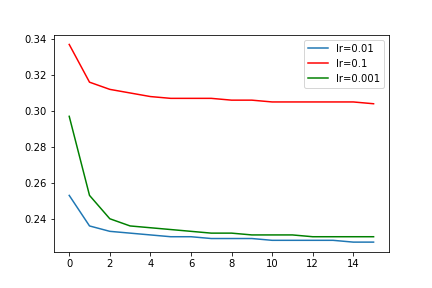
With the learning rate, a learning rate of 0.1 led to a high training loss as compared to 0.01 and 0.001 and we have chose 0.01 as our hyperparameter as it has a good training loss and converges near to the optimal model faster than with a learning rate of 0.001.

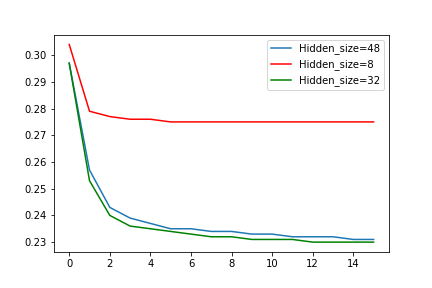
With the hidden size of the 2nd linear layer of our model, a hidden size of 8 will always be performing worse than the 2 other sizes. Therefore, we have chosen to use 32 as the hidden size as it has a comparable training loss when compared with hidden size of 48 and it also plateaued faster on its training loss.

Given that our training model has its training loss plateauing at around 15 epochs which is evident from the graph visualization above, we have also picked 15 as the number of epochs that our model would be trained.

The following shows the loss curve of the training of the model. It is done over 15 epochs.

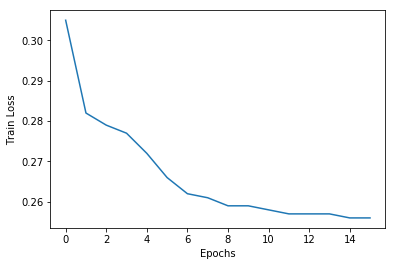

In [5]:
train_losses = np.loadtxt("./data/train_loss_0608-2203.txt", delimiter='\n')
plt.plot(train_losses)
plt.ylabel('Train Loss')
plt.xlabel('Epochs')
plt.show()

## Accuracy

To measure the accuracy of the model, we take the log10 of the absolute difference between the prediction and true retweet value + 1. `log10(|y - t| + 1)`

What this essentially means is that we're looking at whether or not the model is able to arrive on a prediction that is within a certain order of magnitude of the actual retweet value instead of whether or not it is able to accurately predict the retweet count. We interpret this as reasonable implementation of what predicting the "ballpark" figure of a retweet is.

In [28]:
accuracies = np.loadtxt("./data/accuracy_0608-2059.txt", delimiter='\n')

print(f"""
Min Order of Magnitude Deviation: {np.min(accuracies)}
Mean Order of Magnitude Deviation: {np.mean(accuracies)}
Median Order of Magnitude Deviation: {np.mean(accuracies)}
Max Order of Magnitude Deviation: {np.max(accuracies)}
""")

frequency, bins = np.histogram(accuracies, bins=5, range=[0, 5])
accuracies_dist = dict(zip(bins, frequency/len(accuracies) * 100))
accuracies_dist


Min Order of Magnitude Deviation: 0.0
Mean Order of Magnitude Deviation: 0.4959347980368691
Median Order of Magnitude Deviation: 0.4959347980368691
Max Order of Magnitude Deviation: 4.7193975864238835



{0.0: 79.44831353270517,
 1.0: 17.647862094448595,
 2.0: 2.72469495786844,
 3.0: 0.1694901639475946,
 4.0: 0.009639251030194954}

As we can see from the result above, the worst deviation is around `4.72` order of magnitude away (difference of `50,000 retweets`). But this extreme deviation is very rare, as a deviation of `4.0+` occurrs less than `0.01%` of the time in the test set. 

In fact, the model does pretty well in most cases (`~97%` of cases), as its prediction on `79.4%` of test data lands within `0.0 - 0.99` order of magnitude of the actual tweet (difference of `10 retweets`). Afterwhich, `17.6%` of next portion of test data prediction falls within `1.00 - 1.99` order of magnitude (difference of `100 retweet`).

# Discussion

To summarise our approach, our group experimented with:
 - Simple Linear Regression
 - Regression in Pytorch (final model selected)
 - Classification into Regression in Pytorch
 - Regression with XGBoost 

## Comparison with state-of-the-art:
We referenced several papers which also tackled this problem of predicting retweet counts, inclusive of the winner of the CIKM 2020 AnalytiCup competition which the dataset originates from.

A two-phase ensemble model was chosen by researchers of the 2014 paper "A Two-Phase Model for Retweet Number Prediction"(http://shichuan.org/doc/18.pdf), which trained an additional model to classify labeled tweets using an 80-20 heuristic split. However, their dataset was based on the Sina Weibo micro-blog network which had stronger distinctions between the average tweet and those from certain users with high amounts of retweets.

Our project attempted to implement the learnings of this paper by in 3 ways: 1) the same 80-20 rule, 2) K-Means Clustering using the Elbow Method on retweets, and lastly a simple 0-1 binary label for tweets with and without retweets. From our preliminary trials, the addition of labels of the last method had the most significant effect in reducing loss. However, the classifier model did not perform well enough which actually resulted in poorer performance overall.

We then turned our attention to the competition winner's paper "CIKM AnalytiCup 2020: COVID-19 Retweet Prediction with Personalized Attention" (http://ceur-ws.org/Vol-2881/paper1.pdf), which added informational context related to the user through an attention mechanism, which was then run simply into two linear layers.

For our project, we used a far simpler statistical method of compiling a user lookup table from the training data and referenced it to add context about our users to the model (explained in preprocessing). Since the training dataset of 8 million tweets was made by roughly one-third the amount of unique users, (or roughly, that one user made about 3 tweets), we found that the addition of the lookup table was able to great enhance performance even on the test dataset.


## Possible Issues & Improvements
Attention mechanisms seem to successfully provide significant increases in performance as shown in the winner's paper or the earlier 2016 "Retweet Prediction with Attention-based Deep Neural Networks" (http://www.qizhang.info/paper/zhang-lfp0754.pdf) paper, and is likely a preferable alternative to adding user context rather than compiling and storing a huge lookup table like our model does.

Additionally, we utilised mean square error loss on log values which caused our model to prioritise being in the same magnitude of retweets rather than on the actual retweet count. From experiments, the latter would punish the model greatly for guessing too low when high outliers are encountered, resulting in predictions losing their significance since it would output consistently non-zero values. To overcome this, we could have tried experimenting with the absolute difference as the loss function which could have led to a better overall result.

One last improvement that is evident when comparing with the winner's paper is the number of features that they are running into their model (500 vs just 77 in ours), which they achieved by including ratios such as followers to favorites or embedding data such as the entities. With better feature engineering, it is likely that we could have improved the performance of our model.


# GUI

## Running the GUI
0. Download the dataset called `TweetsCOV19_052020.tsv.gz` and save it in `data` directory. Download from: https://zenodo.org/record/4593502#.YQunN4gzZPY
1. Open command line or terminal and navigate to the project folder.
2. Run `pip install -r requirements.txt`. Ensure that `PyQt5`, `gensim` and `torch` are installed among other things.
3. Navigate to `gui` with `cd gui`
4. Then, run `app.py` with `python app.py` or with your IDLE. Note: `app.py` must be executed from `./gui` NOT `root`!

![Open GUI Successfully](assets/gui-open.PNG)

Opening the GUI may take a while (~3 mins) because it will load the dataset from `data/TweetsCOV19_052020.tsv.gz`. Thus, ensure that this file exist in `data` folder!

## Using the GUI

1. Click `Randomize` Button to randomly load a data from dataset.
2. Click `Predict` Button to predict the retweet.

![GUI predicts from existing datapoint](assets/gui-result.PNG)

Optionally:

3. Edit the line edits to create your own custom datapoint before predicting. Note: you will still be referencing the previous user. As shown at the `Username` at bottom right hand corner. i.e. the tweet will be treated as though it comes from this user. 

Note:

- Fields like `Mentions` and `Hashtags` have their own vocab (consult: `data/hashtags_vocab.txt` and `data/mentions_vocab.txt` for valid values. Random values will just get ignored.
- Each fields have their own format, like the ISO date string. Please follow the format strictly, otherwise it will fail to be parsed.
- Some fields can take in multiple values such as `Mentions` and `Hashtags`, in this case, use white space `" "` to delimit values.

![GUI predicts custom datapoint](assets/gui-custom.PNG)

# Sources

1. Source code: https://github.com/arglux/50021-ai-project
2. Report: 
3. Reference papers:
    * Liu G., Shi C., Chen Q., Wu B., Qi J. (2014) A Two-Phase Model for Retweet Number Prediction.
    * Raj, T.V. (2021). CIKM AnalytiCup 2020: COVID-19 Retweet Prediction with Personalized Attention.
    * Zhang, Q., Gong, Y., Wu, J., Huang, H., & Huang, X. (2016). Retweet Prediction with Attention-based Deep Neural Network. 